### Packages and download data

In [1]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

!pip install "torch==1.4" "torchvision==0.5.0" #downgrade the pytorch version to avoid warnings

from fastai.vision import *
from fastai.metrics import error_rate

from google.colab import drive
drive.mount('/content/drive')

     |████████████████████████████████| 753.4 MB 7.0 kB/s 
     |████████████████████████████████| 4.0 MB 39.8 MB/s 
  Attempting uninstall: torch
    Found existing installation: torch 1.9.0+cu102
    Uninstalling torch-1.9.0+cu102:
      Successfully uninstalled torch-1.9.0+cu102
  Attempting uninstall: torchvision
    Found existing installation: torchvision 0.10.0+cu102
    Uninstalling torchvision-0.10.0+cu102:
      Successfully uninstalled torchvision-0.10.0+cu102
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
torchtext 0.10.0 requires torch==1.9.0, but you have torch 1.4.0 which is incompatible.
Mounted at /content/drive


In [2]:
#code reference for the 3 cells below: 
#https://towardsdatascience.com/using-fastai-for-image-classification-54d2b39511ce

!pip install -U -q kaggle
!mkdir -p ~/.kaggle
!echo '{"username":"chrrrrrrrristy","key":"b45495bc7226fae6773b5bfddba217c1"}' > ~/.kaggle/kaggle.json
!chmod 600 ~/.kaggle/kaggle.json

!kaggle datasets download -d zhizhid/dr-2000

100% 1.90G/1.90G [00:17<00:00, 31.2MB/s]
100% 1.90G/1.90G [00:18<00:00, 113MB/s] 


In [3]:
import zipfile
with zipfile.ZipFile("dr-2000.zip","r") as zip_ref:
    zip_ref.extractall("diabetic-data")

In [4]:
path = "./diabetic-data/"

bs = 64 #16, 64 
size = 128 #64, 128, 224

data = ImageDataBunch.from_folder(path, 
                                  valid_pct = 0.2, 
                                  size = size,
                                  bs = bs)

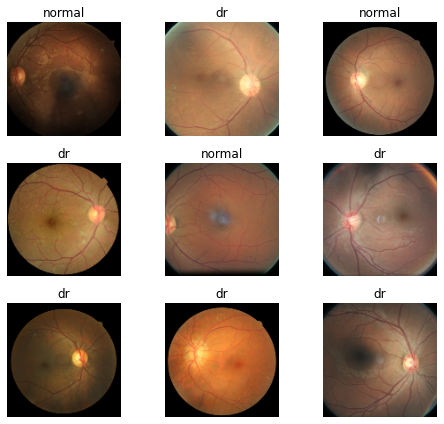

In [ ]:
data.show_batch(rows=3, figsize=(7,6))

### Training and adjust learning rate

In [6]:
#models: resnet50, resnet101
learn = cnn_learner(data, models.resnet101, metrics=error_rate)

Downloading: "https://download.pytorch.org/models/resnet101-5d3b4d8f.pth" to /root/.cache/torch/checkpoints/resnet101-5d3b4d8f.pth


  0%|          | 0.00/170M [00:00<?, ?B/s]

In [ ]:
learn.fit_one_cycle(5)
learn.save('/content/drive/My Drive/Colab Notebooks/6334/stage-1')

epoch,train_loss,valid_loss,error_rate,time
0,1.328627,1.805655,0.420000,07:58
1,1.056819,0.949860,0.380000,07:51
2,0.764092,0.864212,0.407500,07:49
3,0.572773,0.858354,0.377500,07:50
4,0.448153,0.856622,0.377500,07:49


In [7]:
learn.load('/content/drive/My Drive/Colab Notebooks/6334/stage-1')

Learner(data=ImageDataBunch;

Train: LabelList (1600 items)
x: ImageList
Image (3, 128, 128),Image (3, 128, 128),Image (3, 128, 128),Image (3, 128, 128),Image (3, 128, 128)
y: CategoryList
dr,dr,dr,dr,dr
Path: diabetic-data;

Valid: LabelList (400 items)
x: ImageList
Image (3, 128, 128),Image (3, 128, 128),Image (3, 128, 128),Image (3, 128, 128),Image (3, 128, 128)
y: CategoryList
dr,normal,normal,dr,dr
Path: diabetic-data;

Test: None, model=Sequential(
  (0): Sequential(
    (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (4): Sequential(
      (0): Bottleneck(
        (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv2): 

In [8]:
learn.unfreeze()

In [ ]:
#find the best learning rate
learn.lr_find()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


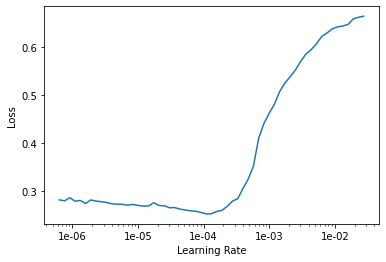

In [ ]:
learn.recorder.plot()

In [9]:
learn.unfreeze()
learn.fit_one_cycle(5, max_lr=slice(1e-6,1e-4))
learn.save('/content/drive/My Drive/Colab Notebooks/6334/stage-2')

epoch,train_loss,valid_loss,error_rate,time
0,0.419848,0.312916,0.117500,07:34
1,0.361612,0.336716,0.127500,07:31
2,0.266288,0.372894,0.137500,07:32
3,0.200887,0.425801,0.142500,07:33
4,0.156888,0.375117,0.132500,07:31


### Results and discussion

In [10]:
learn.load('/content/drive/My Drive/Colab Notebooks/6334/stage-2')

Learner(data=ImageDataBunch;

Train: LabelList (1600 items)
x: ImageList
Image (3, 128, 128),Image (3, 128, 128),Image (3, 128, 128),Image (3, 128, 128),Image (3, 128, 128)
y: CategoryList
dr,dr,dr,dr,dr
Path: diabetic-data;

Valid: LabelList (400 items)
x: ImageList
Image (3, 128, 128),Image (3, 128, 128),Image (3, 128, 128),Image (3, 128, 128),Image (3, 128, 128)
y: CategoryList
dr,normal,normal,dr,dr
Path: diabetic-data;

Test: None, model=Sequential(
  (0): Sequential(
    (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (4): Sequential(
      (0): Bottleneck(
        (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv2): 

In [11]:
interp = ClassificationInterpretation.from_learner(learn)

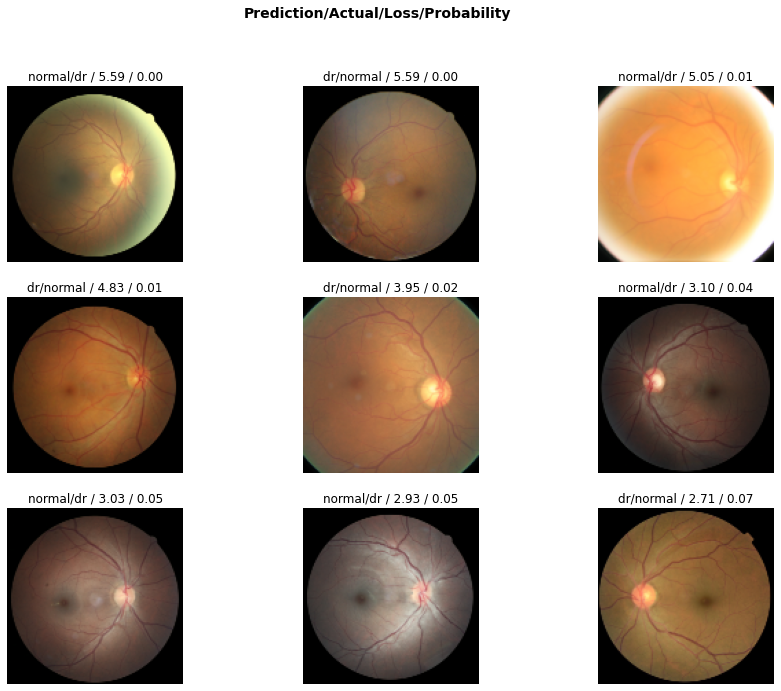

In [12]:
interp.plot_top_losses(9, figsize=(15,11))

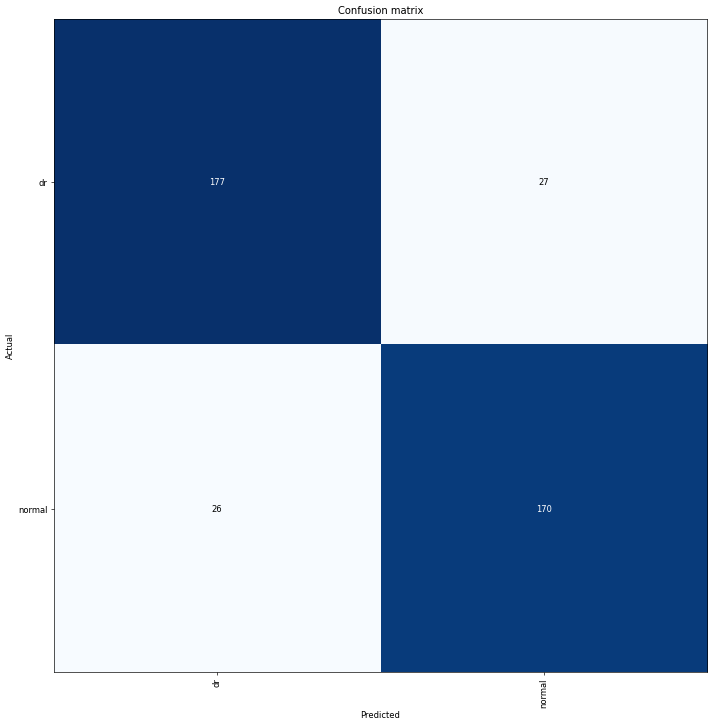

In [13]:
interp.plot_confusion_matrix(figsize=(12,12), dpi=60)

#### Data:

The dataset with 2000 images has randomly divided into training and validation sets using ImageDataBunch.from_folder() with parameter valid_pct = 0.2 so that the training set includes 80% images and validation set includes the other 20%.

#### Model:

1. I have first tried resnet50 for 3 epochs with different parameters, used learn.find_lr() to find the best interval of learning rate and got results below:

* size = 64, batch size = 16: error rate = 0.455 with lr in [1e-5, 1e-2];

* size = 64, batch size = 64: error rate = 0.367 with lr in [1e-4, 1e-2];

* size = 128, batch size = 64: error rate = 0.342 with lr in [1e-4, 1e-2];

* size = 224, batch size = 64: error rate = 0.325  with lr in [1e-3, 1e-2].

It is clear that when I have larger size the error rate decreases, so use size = 224 for next step.

2. From the previous step we can see that resnet50 can't give a error rate below 30%, so I tried resnet101 with size = 224 and batch size = 64. I've first run 5 epochs and got error raye around 0.39, then I used learn.find_lr() and found the best interval of learning rate should be [1e-6,1e-4]. After that I've run another 5 epochs with learning rate in [1e-6,1e-4], and got error rate around 0.12 (actually between 0.1175 to 0.1425).

#### Result:

The confusion matrix shows the result with error rate between 0.1175 to 0.1425. There are 27 dr images classified as normal and 26 normal images as dr.




